In [1]:
import h2o
from sklearn import datasets
import pandas as pd
import numpy as np
from lime import lime_image
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
%matplotlib inline

In [2]:
h2o.init(nthreads=-1)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,13 mins 41 secs
H2O cluster version:,3.10.4.4
H2O cluster version age:,18 days
H2O cluster name:,H2O_from_python_dustin_verzal_5nozys
H2O cluster total nodes:,1
H2O cluster free memory:,5.282 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


In [3]:
# Load Iris dataset
digits = datasets.load_digits()

# Import to H2O frame
X = digits.data
Y = digits.target

df = h2o.H2OFrame(X)
df['target'] = h2o.H2OFrame(Y).asfactor()

# Split frame
train, test = df.split_frame(ratios=[.8], seed=1)

x = set(df.columns) - set(['target'])
y = 'target'

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [4]:
deep = h2o.estimators.deeplearning.H2ODeepLearningEstimator(variable_importances=True)

In [5]:
deep.train(x=x,
           y=y,
           training_frame=train,
           validation_frame=test
           )

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [6]:
explainer = lime_image.LimeImageExplainer()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%
Predicted digit:  0  Actual digit:  0


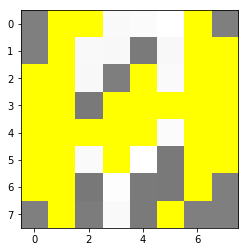

In [7]:
idx = 0
image = h2o.H2OFrame(digits.images[idx])
explanation = explainer.explain_instance(image,
                                         deep.predict,
                                         top_labels=10,
                                         labels=digits.target_names,
                                         hide_color=None,
                                         num_features = 10000,
                                         num_samples=10000,
                                         is_greyscale=True,
                                         is_H2O=True,
                                         batch_size=None)
top_label = explanation.top_labels[0]
temp, mask = explanation.get_image_and_mask(top_label, positive_only=True, num_features=1000, hide_rest=True)
print('Predicted digit: ', top_label, ' Actual digit: ', digits.target[idx])
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

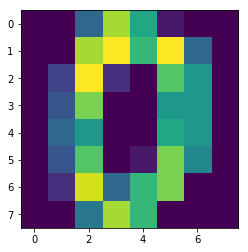

In [8]:
plt.imshow(digits.images[idx])

In [1]:
explanation.top_labels

NameError: name 'explanation' is not defined

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%
Predicted digit:  3  Actual digit:  3


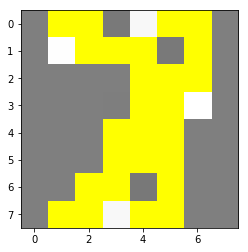

In [17]:
idx = 23
image = h2o.H2OFrame(digits.images[idx])
explanation = explainer.explain_instance(image,
                                         deep.predict,
                                         top_labels=10,
                                         labels=digits.target_names,
                                         hide_color=None,
                                         num_features = 10000,
                                         num_samples=10000,
                                         is_greyscale=True,
                                         is_H2O=True,
                                         batch_size=None)
top_label = explanation.top_labels[0]
temp, mask = explanation.get_image_and_mask(top_label, positive_only=True, num_features=1000, hide_rest=False)
print('Predicted digit: ', top_label, ' Actual digit: ', digits.target[idx])
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

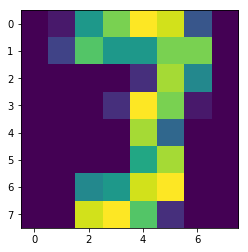

In [18]:
plt.imshow(digits.images[idx])

In [12]:
import skimage
image,
classifier_fn = deep.predict
top_labels=5
hide_color=None
num_samples=100
is_greyscale=True
is_H2O=True

In [114]:
deep.predict(h2o.H2OFrame(digits.images[idx].flatten()).transpose())

Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%


predict,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9
0,1,5.51349e-14,2.23239e-12,3.91079e-16,7.10346e-08,9.95929e-09,4.31595e-08,8.41996e-10,3.2694e-09,3.46757e-11


In [108]:
def data_labels(image,
                fudged_image,
                segments,
                classifier_fn,
                num_samples,
                is_greyscale,
                is_H2O):
    n_features = np.unique(segments).shape[0]
    data = np.random.randint(0, 2, num_samples * n_features).reshape(
                    (num_samples, n_features))

    labels = []
    data[0, :] = 1
    imgs = []
    batch_size = 10

    for row in data:
        temp = copy.deepcopy(image)
        zeros = np.where(row == 0)[0]
        mask = np.zeros(segments.shape).astype(bool)
        for z in zeros:
            mask[segments == z] = True
        temp[mask] = fudged_image[mask]
        if is_greyscale:
            temp = skimage.color.rgb2gray(temp)
        if is_H2O:
            temp = temp.flatten()
        imgs.append(temp)
   
    print(imgs[0])
    if is_H2O:
        preds = classifier_fn(h2o.H2OFrame(np.array(imgs)))
        preds = preds.drop('predict')
        labels = preds.as_data_frame().as_matrix()
    else:
        preds = classifier_fn(np.array(imgs))
        labels.extend(preds)
    return data, np.array(labels)

In [111]:
image = h2o.H2OFrame(digits.images[1])
if is_H2O:
    image = image.as_data_frame().as_matrix()

if is_greyscale:
    image = skimage.color.grey2rgb(image)

segments = skimage.segmentation.quickshift(image, kernel_size=4,
                      max_dist=200, ratio=0.4)

fudged_image = image.copy()
if hide_color is None:
    for x in np.unique(segments):
        fudged_image[segments == x] = (
            np.mean(image[segments == x][:, 0]),
            np.mean(image[segments == x][:, 1]),
            np.mean(image[segments == x][:, 2]))
else:
    fudged_image[:] = hide_color

data, labels = data_labels(image, fudged_image, segments,
                                classifier_fn, num_samples,
                                is_greyscale=is_greyscale, is_H2O=is_H2O)

Parse progress: |█████████████████████████████████████████████████████████| 100%


C:\Users\Dustin.Verzal\Downloads\Anaconda\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


[  5.42101086e-20   5.42101086e-20   5.42101086e-20   1.35525272e-18
   1.46367293e-18   5.96311195e-19   5.42101086e-20   5.42101086e-20
   5.42101086e-20   5.42101086e-20   5.42101086e-20   1.24683250e-18
   1.78893358e-18   1.02999206e-18   5.42101086e-20   5.42101086e-20
   5.42101086e-20   5.42101086e-20   3.79470760e-19   1.68051337e-18
   1.78893358e-18   7.04731412e-19   5.42101086e-20   5.42101086e-20
   5.42101086e-20   8.13151629e-19   1.68051337e-18   1.78893358e-18
   1.78893358e-18   2.71050543e-19   5.42101086e-20   5.42101086e-20
   5.42101086e-20   5.42101086e-20   1.62630326e-19   1.78893358e-18
   1.78893358e-18   3.79470760e-19   5.42101086e-20   5.42101086e-20
   5.42101086e-20   5.42101086e-20   1.62630326e-19   1.78893358e-18
   1.78893358e-18   7.04731412e-19   5.42101086e-20   5.42101086e-20
   5.42101086e-20   5.42101086e-20   1.62630326e-19   1.78893358e-18
   1.78893358e-18   7.04731412e-19   5.42101086e-20   5.42101086e-20
   5.42101086e-20   5.42101086e-20

In [114]:
temp = copy.deepcopy(image)
zeros = np.where(row == 0)[0]
mask = np.zeros(segments.shape).astype(bool)

In [113]:
for z in zeros:
    mask[segments == z] = True
temp[mask] = fudged_image[mask]
if is_greyscale:
    temp = skimage.color.rgb2gray(temp)
if is_H2O:
    temp = temp.flatten()

array([  4.87890978e-19,   4.87890978e-19,   4.87890978e-19,
         4.87890978e-19,   4.87890978e-19,   4.87890978e-19,
         4.87890978e-19,   4.87890978e-19,   4.87890978e-19,
         4.87890978e-19,   4.87890978e-19,   4.87890978e-19,
         4.87890978e-19,   4.87890978e-19,   4.87890978e-19,
         4.87890978e-19,   4.87890978e-19,   4.87890978e-19,
         4.87890978e-19,   4.87890978e-19,   4.87890978e-19,
         4.87890978e-19,   4.87890978e-19,   4.87890978e-19,
         4.87890978e-19,   4.87890978e-19,   4.87890978e-19,
         4.87890978e-19,   4.87890978e-19,   4.87890978e-19,
         4.87890978e-19,   4.87890978e-19,   4.87890978e-19,
         4.87890978e-19,   4.87890978e-19,   4.87890978e-19,
         4.87890978e-19,   4.87890978e-19,   4.87890978e-19,
         4.87890978e-19,   4.87890978e-19,   4.87890978e-19,
         4.87890978e-19,   4.87890978e-19,   4.87890978e-19,
         4.87890978e-19,   4.87890978e-19,   4.87890978e-19,
         4.87890978e-19,